## AI Platform: Qwik Start
This assignment is based on the resource in https://www.qwiklabs.com/focuses/581?parent=catalog

## This assignment gives you an introductory, end-to-end experience of training and prediction on AI Platform. Here, you will use a census dataset to:

- Create a TensorFlow 2.x training application and validate it locally.
- Submitting your training job on Google cloud
- Deploy a model to support prediction. Here your final model will be exposed as a URL so that you can then invoke a "predict" command to apply it to test data.
- Request an online prediction and see the response.

In [1]:
import os

### Task 0: Get your training data

The relevant data files, adult.data and adult.test, are hosted in a public Cloud Storage bucket.

You can read the files directly from Cloud Storage or copy them to your local environment. You will download the samples for local training, and later upload them to your own Cloud Storage bucket for cloud training.

Run the following command to download the data to a local file directory and **set** variables that point to the downloaded data files:

In [2]:
%%bash

mkdir data
gsutil -m cp gs://cloud-samples-data/ml-engine/census/data/* data/

Copying gs://cloud-samples-data/ml-engine/census/data/adult.data.csv...
Copying gs://cloud-samples-data/ml-engine/census/data/adult.test.csv...
Copying gs://cloud-samples-data/ml-engine/census/data/census.test.csv...
Copying gs://cloud-samples-data/ml-engine/census/data/test.json...
Copying gs://cloud-samples-data/ml-engine/census/data/census.train.csv...
Copying gs://cloud-samples-data/ml-engine/census/data/test.csv...
/ [6/6 files][ 10.7 MiB/ 10.7 MiB] 100% Done                                    
Operation completed over 6 objects/10.7 MiB.                                     


## Now you have copied the data from the public bucket "gs://cloud-samples-data/ml-engine/census/data" to local.

In [3]:
%%bash

head data/adult.data.csv

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, <=50K
52, Self-emp-not-inc, 209642, HS-grad, 9, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 45, United-States, >50K
31, 

In [4]:
%%bash

export TRAIN_DATA=$(pwd)/data/adult.data.csv
export EVAL_DATA=$(pwd)/data/adult.test.csv

## Task 1: Exploratory Data Analysis (EDA)


1.   The last column represents "income_bracket"(<=50k is label 0, >50k is label 1) is label 'y'. Extract this column as label 'y'
2.   Plot the distribution of labels
3.  It is given that the features named: ['fnlwgt', 'education', 'gender'] dont impact 'income_bracket', so they can be ignored. For all other categorical and numerical features, apply the "preprocess_data" function below to clean the data followed by feature ranking.

[OPTIONAL] You may modify the categorical encoding commands with your own version to one-hot encode categorical features. 
Find the features that are most important for predicting "income_bracket".

In [28]:
_CSV_COLUMNS = [
'age', 'workclass', 'fnlwgt', 'education', 'education_num',
'marital_status', 'occupation', 'relationship', 'race', 'gender',
'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
'income_bracket'
  ]

def preprocess_data(dataframe):
    """Converts categorical features to numeric. Removes unused columns.

    Args:
      dataframe: Pandas dataframe with raw data

    Returns:
      Dataframe with preprocessed data
    """
    _CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
      ]
    dataframe.columns=_CSV_COLUMNS


# These are columns we will not use as features for training. There are many
# reasons not to use certain attributes of data for training. Perhaps their
# values are noisy or inconsistent, or perhaps they encode bias that we do not
# want our model to learn. For a deep dive into the features of this Census
# dataset and the challenges they pose, see the Introduction to ML Fairness
# Notebook: https://colab.research.google.com/github/google/eng-edu/blob
# /master/ml/cc/exercises/intro_to_fairness.ipynb
    UNUSED_COLUMNS = ['fnlwgt', 'education', 'gender']
    _CATEGORICAL_TYPES = {
    'workclass': pd.api.types.CategoricalDtype(categories=[
        'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'
    ]),
    'marital_status': pd.api.types.CategoricalDtype(categories=[
        'Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'
    ]),
    'occupation': pd.api.types.CategoricalDtype([
        'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
        'Sales', 'Tech-support', 'Transport-moving'
    ]),
    'relationship': pd.api.types.CategoricalDtype(categories=[
        'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
        'Wife'
    ]),
    'race': pd.api.types.CategoricalDtype(categories=[
        'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'
    ]),
    'native_country': pd.api.types.CategoricalDtype(categories=[
        'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic',
        'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece',
        'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong',
        'Hungary',
        'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos',
        'Mexico',
        'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines',
        'Poland',
        'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
        'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'
    ]),
    'income_bracket': pd.api.types.CategoricalDtype(categories=[
        '<=50K', '>50K'
    ])
               }



    dataframe = dataframe.drop(columns=UNUSED_COLUMNS)

    # Convert integer valued (numeric) columns to floating point
    numeric_columns = dataframe.select_dtypes(['int64']).columns
    dataframe[numeric_columns] = dataframe[numeric_columns].astype('float32')

    # Convert categorical columns to numeric
    # ########################[OPTIONAL] You may write code to modify this section!
    cat_columns = dataframe.select_dtypes(['object']).columns
    print(cat_columns)
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.astype(
        _CATEGORICAL_TYPES[x.name]))
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.cat.codes)
    return dataframe

In [29]:
###################Write code to import libraries and then to print first few rows of the train data set
import pandas as pd 

dataset=pd.read_csv('https://storage.googleapis.com/cloud-samples-data/ai-platform/census/data/adult.data.csv', names=_CSV_COLUMNS)

Index(['workclass', 'marital_status', 'occupation', 'relationship', 'race',
       'native_country', 'income_bracket'],
      dtype='object')


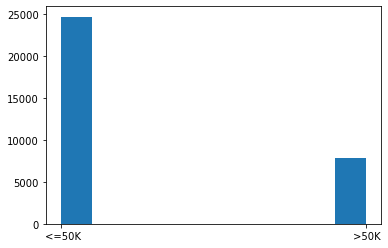

In [ ]:
#################### Write code to print the distribution of the 'y' label (the income bracket column)

dataset.income_bracket.value_counts().plot.bar()

In [ ]:
# [OPTIONAL] Perform feature ranking after one-hot encoding the categorical columns

## Next, run feature ranking using randomforest or sklearn feature ranking and report the features that should be considered for prediction here.

# Task 2: Run a local training job

A local training job loads your Python training program and starts a training process in an environment that's similar to that of a live Cloud AI Platform cloud training job.


#### 1. Create files to hold the Python program

To do that, let's create three files. The first, called util.py, will contain utility methods for cleaning and preprocessing the data, as well as performing any feature engineering needed by transforming and normalizing the data. 
This is a way of wrapping functions.

In [35]:
%%bash
mkdir -p trainer
touch trainer/__init__.py

In [36]:
%%writefile trainer/util.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from six.moves import urllib
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf

# Storage directory
DATA_DIR = os.path.join(tempfile.gettempdir(), 'census_data')

# Download options.
DATA_URL = (
    'https://storage.googleapis.com/cloud-samples-data/ai-platform/census'
    '/data')
TRAINING_FILE = 'adult.data.csv'
EVAL_FILE = 'adult.test.csv'
TRAINING_URL = '%s/%s' % (DATA_URL, TRAINING_FILE)
EVAL_URL = '%s/%s' % (DATA_URL, EVAL_FILE)

# These are the features in the dataset.
# Dataset information: https://archive.ics.uci.edu/ml/datasets/census+income
_CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]

# This is the label (target) we want to predict.
_LABEL_COLUMN = 'income_bracket'

# These are columns we will not use as features for training. There are many
# reasons not to use certain attributes of data for training. Perhaps their
# values are noisy or inconsistent, or perhaps they encode bias that we do not
# want our model to learn. For a deep dive into the features of this Census
# dataset and the challenges they pose, see the Introduction to ML Fairness
# Notebook: https://colab.research.google.com/github/google/eng-edu/blob
# /master/ml/cc/exercises/intro_to_fairness.ipynb
UNUSED_COLUMNS = ['fnlwgt', 'education', 'gender']

_CATEGORICAL_TYPES = {
    'workclass': pd.api.types.CategoricalDtype(categories=[
        'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'
    ]),
    'marital_status': pd.api.types.CategoricalDtype(categories=[
        'Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'
    ]),
    'occupation': pd.api.types.CategoricalDtype([
        'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
        'Sales', 'Tech-support', 'Transport-moving'
    ]),
    'relationship': pd.api.types.CategoricalDtype(categories=[
        'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
        'Wife'
    ]),
    'race': pd.api.types.CategoricalDtype(categories=[
        'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'
    ]),
    'native_country': pd.api.types.CategoricalDtype(categories=[
        'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic',
        'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece',
        'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong',
        'Hungary',
        'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos',
        'Mexico',
        'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines',
        'Poland',
        'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
        'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'
    ]),
    'income_bracket': pd.api.types.CategoricalDtype(categories=[
        '<=50K', '>50K'
    ])
}


def _download_and_clean_file(filename, url):
    """Downloads data from url, and makes changes to match the CSV format.

    The CSVs may use spaces after the comma delimters (non-standard) or include
    rows which do not represent well-formed examples. This function strips out
    some of these problems.

    Args:
      filename: filename to save url to
      url: URL of resource to download
    """
    temp_file, _ = urllib.request.urlretrieve(url)
    with tf.io.gfile.GFile(temp_file, 'r') as temp_file_object:
        with tf.io.gfile.GFile(filename, 'w') as file_object:
            for line in temp_file_object:
                line = line.strip()
                line = line.replace(', ', ',')
                if not line or ',' not in line:
                    continue
                if line[-1] == '.':
                    line = line[:-1]
                line += '\n'
                file_object.write(line)
    tf.io.gfile.remove(temp_file)


def download(data_dir):
    """Downloads census data if it is not already present.

    Args:
      data_dir: directory where we will access/save the census data
    """
    tf.io.gfile.makedirs(data_dir)

    training_file_path = os.path.join(data_dir, TRAINING_FILE)
    if not tf.io.gfile.exists(training_file_path):
        _download_and_clean_file(training_file_path, TRAINING_URL)

    eval_file_path = os.path.join(data_dir, EVAL_FILE)
    if not tf.io.gfile.exists(eval_file_path):
        _download_and_clean_file(eval_file_path, EVAL_URL)

    return training_file_path, eval_file_path


def preprocess(dataframe):
    """Converts categorical features to numeric. Removes unused columns.

    Args:
      dataframe: Pandas dataframe with raw data

    Returns:
      Dataframe with preprocessed data
    """
    dataframe = dataframe.drop(columns=UNUSED_COLUMNS)

    # Convert integer valued (numeric) columns to floating point
    numeric_columns = dataframe.select_dtypes(['int64']).columns
    dataframe[numeric_columns] = dataframe[numeric_columns].astype('float32')

    # Convert categorical columns to numeric
    cat_columns = dataframe.select_dtypes(['object']).columns
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.astype(
        _CATEGORICAL_TYPES[x.name]))
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.cat.codes)
    return dataframe


def standardize(dataframe):
    """Scales numerical columns using their means and standard deviation to get
    z-scores: the mean of each numerical column becomes 0, and the standard
    deviation becomes 1. This can help the model converge during training.

    Args:
      dataframe: Pandas dataframe

    Returns:
      Input dataframe with the numerical columns scaled to z-scores
    """
    dtypes = list(zip(dataframe.dtypes.index, map(str, dataframe.dtypes)))
    # Normalize numeric columns.
    for column, dtype in dtypes:
        if dtype == 'float32':
            dataframe[column] -= dataframe[column].mean()
            dataframe[column] /= dataframe[column].std()
    return dataframe


def load_data():
    """Loads data into preprocessed (train_x, train_y, eval_y, eval_y)
    dataframes.

    Returns:
      A tuple (train_x, train_y, eval_x, eval_y), where train_x and eval_x are
      Pandas dataframes with features for training and train_y and eval_y are
      numpy arrays with the corresponding labels.
    """
    # Download Census dataset: Training and eval csv files.
    training_file_path, eval_file_path = download(DATA_DIR)

    # This census data uses the value '?' for missing entries. We use
    # na_values to
    # find ? and set it to NaN.
    # https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv
    # .html
    train_df = pd.read_csv(training_file_path, names=_CSV_COLUMNS,
                           na_values='?')
    eval_df = pd.read_csv(eval_file_path, names=_CSV_COLUMNS, na_values='?')

    train_df = preprocess(train_df)
    eval_df = preprocess(eval_df)

    # Split train and eval data with labels. The pop method copies and removes
    # the label column from the dataframe.
    train_x, train_y = train_df, train_df.pop(_LABEL_COLUMN)
    eval_x, eval_y = eval_df, eval_df.pop(_LABEL_COLUMN)

    # Join train_x and eval_x to normalize on overall means and standard
    # deviations. Then separate them again.
    all_x = pd.concat([train_x, eval_x], keys=['train', 'eval'])
    all_x = standardize(all_x)
    train_x, eval_x = all_x.xs('train'), all_x.xs('eval')

    # Reshape label columns for use with tf.data.Dataset
    train_y = np.asarray(train_y).astype('float32').reshape((-1, 1))
    eval_y = np.asarray(eval_y).astype('float32').reshape((-1, 1))

    return train_x, train_y, eval_x, eval_y

Writing trainer/util.py


The second file, called model.py, defines the input function and the model architecture. In this example, we use tf.data API for the data pipeline and create the model using the Keras Sequential API. We define a DNN with an input layer and 3 additonal layers using the Relu activation function. Since the task is a binary classification, the output layer uses the sigmoid activation.

In [37]:
%%writefile trainer/model.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf


def input_fn(features, labels, shuffle, num_epochs, batch_size):
    """Generates an input function to be used for model training.

    Args:
      features: numpy array of features used for training or inference
      labels: numpy array of labels for each example
      shuffle: boolean for whether to shuffle the data or not (set True for
        training, False for evaluation)
      num_epochs: number of epochs to provide the data for
      batch_size: batch size for training

    Returns:
      A tf.data.Dataset that can provide data to the Keras model for training or
        evaluation
    """
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    return dataset


def create_keras_model(input_dim, learning_rate):
    """Creates Keras Model for Binary Classification.

    The single output node + Sigmoid activation makes this a Logistic
    Regression.

    Args:
      input_dim: How many features the input has
      learning_rate: Learning rate for training

    Returns:
      The compiled Keras model (still needs to be trained)
    """
    Dense = tf.keras.layers.Dense
    model = tf.keras.Sequential(
        [
            Dense(100, activation=tf.nn.relu, kernel_initializer='uniform',
                  input_shape=(input_dim,)),
            Dense(75, activation=tf.nn.relu),
            Dense(50, activation=tf.nn.relu),
            Dense(25, activation=tf.nn.relu),
            Dense(1, activation=tf.nn.sigmoid)
        ])

    # Custom Optimizer:
    # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
    optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)

    # Compile Keras model
    model.compile(
        loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Writing trainer/model.py


The last file, called task.py, trains on data loaded and preprocessed in util.py. Using the tf.distribute.MirroredStrategy() sope, it is possible to train on a distributed fashion. The trained model is then saved in a TensorFlow SavedModel format.

In [38]:
%%writefile trainer/task.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os

from . import model
from . import util

import tensorflow as tf


def get_args():
    """Argument parser.

    Returns:
      Dictionary of arguments.
    """
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--job-dir',
        type=str,
        required=True,
        help='local or GCS location for writing checkpoints and exporting '
             'models')
    parser.add_argument(
        '--num-epochs',
        type=int,
        default=20,
        help='number of times to go through the data, default=20')
    parser.add_argument(
        '--batch-size',
        default=128,
        type=int,
        help='number of records to read during each training step, default=128')
    parser.add_argument(
        '--learning-rate',
        default=.01,
        type=float,
        help='learning rate for gradient descent, default=.01')
    parser.add_argument(
        '--verbosity',
        choices=['DEBUG', 'ERROR', 'FATAL', 'INFO', 'WARN'],
        default='INFO')
    args, _ = parser.parse_known_args()
    return args


def train_and_evaluate(args):
    """Trains and evaluates the Keras model.

    Uses the Keras model defined in model.py and trains on data loaded and
    preprocessed in util.py. Saves the trained model in TensorFlow SavedModel
    format to the path defined in part by the --job-dir argument.

    Args:
      args: dictionary of arguments - see get_args() for details
    """

    train_x, train_y, eval_x, eval_y = util.load_data()

    # dimensions
    num_train_examples, input_dim = train_x.shape
    num_eval_examples = eval_x.shape[0]

    # Create the Keras Model
    keras_model = model.create_keras_model(
        input_dim=input_dim, learning_rate=args.learning_rate)

    # Pass a numpy array by passing DataFrame.values
    training_dataset = model.input_fn(
        features=train_x.values,
        labels=train_y,
        shuffle=True,
        num_epochs=args.num_epochs,
        batch_size=args.batch_size)

    # Pass a numpy array by passing DataFrame.values
    validation_dataset = model.input_fn(
        features=eval_x.values,
        labels=eval_y,
        shuffle=False,
        num_epochs=args.num_epochs,
        batch_size=num_eval_examples)

    # Setup Learning Rate decay.
    lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: args.learning_rate + 0.02 * (0.5 ** (1 + epoch)),
        verbose=True)

    # Setup TensorBoard callback.
    tensorboard_cb = tf.keras.callbacks.TensorBoard(
        os.path.join(args.job_dir, 'keras_tensorboard'),
        histogram_freq=1)

    # Train model
    keras_model.fit(
        training_dataset,
        steps_per_epoch=int(num_train_examples / args.batch_size),
        epochs=args.num_epochs,
        validation_data=validation_dataset,
        validation_steps=1,
        verbose=1,
        callbacks=[lr_decay_cb, tensorboard_cb])

    export_path = os.path.join(args.job_dir, 'keras_export')
    tf.keras.models.save_model(keras_model, export_path)
    print('Model exported to: {}'.format(export_path))



if __name__ == '__main__':
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        args = get_args()
        tf.compat.v1.logging.set_verbosity(args.verbosity)
        train_and_evaluate(args)


Writing trainer/task.py


#### 2: Run a training job locally using the Python training program

**NOTE** When you run the same training job on AI Platform later in the lab, you'll see that the command is not much different from the above.

Specify an output directory and set a MODEL_DIR variable to hold the trained model, then run the training job locally by running the following command (by default, verbose logging is turned off. You can enable it by setting the --verbosity tag to DEBUG):

### In the cell below enter additional parameters:
*   train-steps=1000
*   eval-steps=100



In [39]:
%%bash

MODEL_DIR=output
gcloud ai-platform local train \
    --module-name trainer.task \
    --package-path trainer/ \
    --job-dir $MODEL_DIR \
    -- \
    --train-files $TRAIN_DATA \
    --eval-files $EVAL_DATA \
    --train-steps 1000 \
    --eval-steps 100
#This command is INCOMPLETE, please complete by adding train and validation steps first and then run it.

Train for 254 steps, validate for 1 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.02.
Epoch 1/20
254/254 [==============================] - 7s 26ms/step - loss: 0.5194 - accuracy: 0.7834 - val_loss: 0.4075 - val_accuracy: 0.7857

Epoch 00002: LearningRateScheduler reducing learning rate to 0.015.
Epoch 2/20
254/254 [==============================] - 2s 8ms/step - loss: 0.3660 - accuracy: 0.8341 - val_loss: 0.3411 - val_accuracy: 0.8427

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 3/20
254/254 [==============================] - 2s 8ms/step - loss: 0.3427 - accuracy: 0.8429 - val_loss: 0.3464 - val_accuracy: 0.8449

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01125.
Epoch 4/20
254/254 [==============================] - 2s 8ms/step - loss: 0.3381 - accuracy: 0.8453 - val_loss: 0.3330 - val_accuracy: 0.8500

Epoch 00005: LearningRateScheduler reducing learning rate to 0.010625.
Epoch 5/20
254/254 [===================

2021-12-11 11:45:44.715200: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200210000 Hz
2021-12-11 11:45:44.717039: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5579cd656240 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-11 11:45:44.717113: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-11 11:45:44.719465: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-12-11 11:45:49.946665: I tensorflow/core/profiler/lib/profiler_session.cc:225] Profiler session started.
2021-12-11 11:45:55.083811: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2021-12-11 11:45:57.123139: W tensorflow/core/kernels/data/generator_

Check if the output has been written to the output folder:

In [40]:
%%bash

ls output/keras_export/

assets
saved_model.pb
variables


#### 3: Prepare input for prediction

To receive valid and useful predictions, you must preprocess input for prediction in the same way that training data was preprocessed. In a production system, you may want to create a preprocessing pipeline that can be used identically at training time and prediction time.

For this exercise, use the training package's data-loading code to select a random sample from the evaluation data. This data is in the form that was used to evaluate accuracy after each epoch of training, so it can be used to send test predictions without further preprocessing.


Run the following snippet of code to preprocess the raw data from the adult.test.csv file. Here, we are grabbing 5 examples to run predictions on:

In [41]:
from trainer import util
_, _, eval_x, eval_y = util.load_data()

prediction_input = eval_x.sample(5)
prediction_targets = eval_y[prediction_input.index]

Check the numerical representation of the features by printing the preprocessed data:

In [42]:
print(prediction_input)

            age  workclass  education_num  marital_status  occupation  \
6274  -1.432683          3      -0.808418               4           6   
12348 -0.703343          3      -0.419365               2           4   
12228 -0.557475          5      -0.419365               4           7   
6465  -0.046938          3      -0.030311               2          13   
11169 -0.557475          3      -2.753686               4          13   

       relationship  race  capital_gain  capital_loss  hours_per_week  \
6274              3     4     -0.144807     -0.217119       -0.034043   
12348             0     4     -0.144807     -0.217119       -0.034043   
12228             1     4     -0.144807     -0.217119       -1.083270   
6465              0     4      0.550092     -0.217119       -0.034043   
11169             1     4     -0.144807     -0.217119       -0.841140   

       native_country  
6274               38  
12348              38  
12228              38  
6465               38  
11

Notice that categorical fields, like occupation, have already been converted to integers (with the same mapping that was used for training). Numerical fields, like age, have been scaled to a z-score. Some fields have been dropped from the original data.

Export the prediction input to a newline-delimited JSON file:

In [43]:
import json

with open('test.json', 'w') as json_file:
  for row in prediction_input.values.tolist():
    json.dump(row, json_file)
    json_file.write('\n')

Inspect the .json file:

In [44]:
%%bash

cat test.json

[-1.432682752609253, 3.0, -0.8084180951118469, 4.0, 6.0, 3.0, 4.0, -0.14480669796466827, -0.2171185314655304, -0.034042954444885254, 38.0]
[-0.7033432126045227, 3.0, -0.4193645119667053, 2.0, 4.0, 0.0, 4.0, -0.14480669796466827, -0.2171185314655304, -0.034042954444885254, 38.0]
[-0.5574752688407898, 5.0, -0.4193645119667053, 4.0, 7.0, 1.0, 4.0, -0.14480669796466827, -0.2171185314655304, -1.0832695960998535, 38.0]
[-0.046937547624111176, 3.0, -0.03031095676124096, 2.0, 13.0, 0.0, 4.0, 0.5500917434692383, -0.2171185314655304, -0.034042954444885254, 38.0]
[-0.5574752688407898, 3.0, -2.75368595123291, 4.0, 13.0, 1.0, 4.0, -0.14480669796466827, -0.2171185314655304, -0.8411403298377991, 7.0]


#### 4: Use your trained model for prediction

Once you've trained your TensorFlow model, you can use it for prediction on new data. In this case, you've trained a census model to predict income category given some information about a person.

Run the following command to run prediction on the test.json file we created above:

In [45]:
%%bash

gcloud ai-platform local predict \
    --model-dir output/keras_export/ \
    --json-instances ./test.json

DENSE_4
[2.5943299988284707e-05]
[0.07954646646976471]
[0.00040580486529506743]
[0.469955176115036]
[3.5284068871987984e-05]


If the signature defined in the model is not serving_default then you must specify it via --signature-name flag, otherwise the command may fail.
Instructions for updating:
non-resource variables are not supported in the long term
2021-12-11 12:29:47.629352: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200210000 Hz
2021-12-11 12:29:47.629648: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ad6965d230 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-11 12:29:47.629677: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-11 12:29:47.629993: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.l

Since the model's last layer uses a sigmoid function for its activation, outputs between 0 and 0.5 represent negative predictions **("<=50K")** and outputs between 0.5 and 1 represent positive ones **(">50K")**.

# Task 3: Run your training job in the cloud

Now that you've validated your model by running it locally, you will now get practice training using Cloud AI Platform.

**Note:** The initial job request will take several minutes to start, but subsequent jobs run more quickly. This enables quick iteration as you develop and validate your training job.

First, set the following variables:


In [46]:
%%bash
export PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "${PROJECT}

Your current GCP Project Name is: fb-mlops-nov-21


In [69]:
PROJECT = "fb-mlops-nov-21"  # Replace with your project name
BUCKET_NAME=PROJECT+"-alejandro-aiplatform" #Replace with your firstname here
REGION="us-central1" #Replace with your nearest ZONE here

In [70]:
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET_NAME"] = BUCKET_NAME
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "2.1"
os.environ["PYTHONVERSION"] = "3.7"

### 1: Set up a Cloud Storage bucket

The AI Platform services need to access Cloud Storage (GCS) to read and write data during model training and batch prediction.

Create a bucket using BUCKET_NAME as the name for the bucket and copy the data into it.

In [71]:
%%bash

if ! gsutil ls | grep -q gs://${BUCKET_NAME}; then
    gsutil mb -l ${REGION} gs://${BUCKET_NAME}
fi
gsutil cp -r data gs://$BUCKET_NAME/data

Creating gs://fb-mlops-nov-21-alejandro-aiplatform/...
Copying file://data/test.csv [Content-Type=text/csv]...
Copying file://data/test.json [Content-Type=application/json]...                
Copying file://data/census.test.csv [Content-Type=text/csv]...                  
Copying file://data/adult.test.csv [Content-Type=text/csv]...                   
- [4 files][  3.6 MiB/  3.6 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://data/census.train.csv [Content-Type=text/csv]...
Copying file://data/adult.data.csv [Content-Type=text/csv]...                   
\ [6 files][ 10.7 MiB/ 10.7 MiB]                                                
Operation completed over 6 objects/10.7 MiB.                                     


Set the TRAIN_DATA and EVAL_DATA variables to point to the files:

In [72]:
%%bash

export TRAIN_DATA=gs://$BUCKET_NAME/data/adult.data.csv
export EVAL_DATA=gs://$BUCKET_NAME/data/adult.test.csv

Use gsutil again to copy the JSON test file test.json to your Cloud Storage bucket:

In [73]:
%%bash

gsutil cp test.json gs://$BUCKET_NAME/data/test.json

Copying file://test.json [Content-Type=application/json]...
/ [1 files][  695.0 B/  695.0 B]                                                
Operation completed over 1 objects/695.0 B.                                      


Set the TEST_JSON variable to point to that file:

In [74]:
%%bash

export TEST_JSON=gs://$BUCKET_NAME/data/test.json

#### 2: Run a single-instance trainer in the cloud

With a validated training job that runs in both single-instance and distributed mode, you're now ready to run a training job in the cloud. For this example, we will be requesting a single-instance training job.

Use the default BASIC scale tier to run a single-instance training job. The initial job request can take a few minutes to start, but subsequent jobs run more quickly. This enables quick iteration as you develop and validate your training job.

Select a name for the initial training run that distinguishes it from any subsequent training runs. For example, we can use date and time to compose the job id.

Specify a directory for output generated by AI Platform by setting an OUTPUT_PATH variable to include when requesting training and prediction jobs. The OUTPUT_PATH represents the fully qualified Cloud Storage location for model checkpoints, summaries, and exports. You can use the BUCKET_NAME variable you defined in a previous step. It's a good practice to use the job name as the output directory.

Run the following command to submit a training job in the cloud that uses a single process. This time, set the --verbosity tag to DEBUG so that you can inspect the full logging output and retrieve accuracy, loss, and other metrics. The output also contains a number of other warning messages that you can ignore for the purposes of this sample:

In [89]:
%%bash

JOB_ID=census_$(date -u +%y%m%d_%H%M%S)
OUTPUT_PATH=gs://$BUCKET_NAME/$JOB_ID
gcloud ai-platform jobs submit training $JOB_ID \
    --job-dir $OUTPUT_PATH \
    --runtime-version $TFVERSION \
    --python-version $PYTHONVERSION \
    --module-name trainer.task \
    --package-path trainer/ \
    --region $REGION \
    -- \
    --train-files $TRAIN_DATA \
    --eval-files $EVAL_DATA \
    --train-steps 1000 \
    --eval-steps 100 \
    --verbosity DEBUG

jobId: census_211211_123907
state: QUEUED


Job [census_211211_123907] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe census_211211_123907

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs census_211211_123907


See the job bein cued at https://console.cloud.google.com/ai-platform/jobs?

Set an environment variable with the jobId generated above:

In [96]:
os.environ["JOB_ID"] = "census_211211_123122" ######### Replace with your job id as shown above

You can monitor the progress of your training job by watching the logs on the command line by running:

`gcloud ai-platform jobs stream-logs $JOB_ID`

Or monitor it in the Console at `AI Platform > Jobs`. Wait until your AI Platform training job is done. It is finished when you see a green check mark by the jobname in the Cloud Console, or when you see the message Job completed successfully from the Cloud Shell command line.

#### 3: Deploy your model to support prediction

By deploying your trained model to AI Platform to serve online prediction requests, you get the benefit of scalable serving. This is useful if you expect your trained model to be hit with many prediction requests in a short period of time.


**Create an AI Platform model:**

In [97]:
############ENTER HERE#########################
MODEL_NAME = "census_alejandro2" #REPLACE your firstname here

! gcloud ai-platform models create $MODEL_NAME \
  --region $REGION

Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/fb-mlops-nov-21/models/census_alejandro2].


In [98]:
#ENTER HERE#####################
MODEL_VERSION = "v_alejandro" # Give a unique name <v_firstname>

## Now you need to find the origin path for the model binaries to create a mode version. Run the command below and substitute it next to "origin" in the model version creation command

In [99]:
! echo gs://$BUCKET_NAME/$JOB_ID/keras_export/

gs://fb-mlops-nov-21-alejandro-aiplatform/census_211211_123122/keras_export/


In [100]:
#This command creates a version of the model. Susbtitute the path above next to "origin" here
! gcloud ai-platform versions create $MODEL_VERSION --model $MODEL_NAME --origin gs://fb-mlops-nov-21-alejandro-aiplatform/census_211211_123122/keras_export/ --region us-central1 --runtime-version 2.1 --python-version 3.7 --framework tensorflow 



Using endpoint [https://us-central1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.versions.create) FAILED_PRECONDITION: Field: version.deployment_uri Error: The provided URI for model files doesn't contain any objects.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: The provided URI for model files doesn't contain any objects.
    field: version.deployment_uri


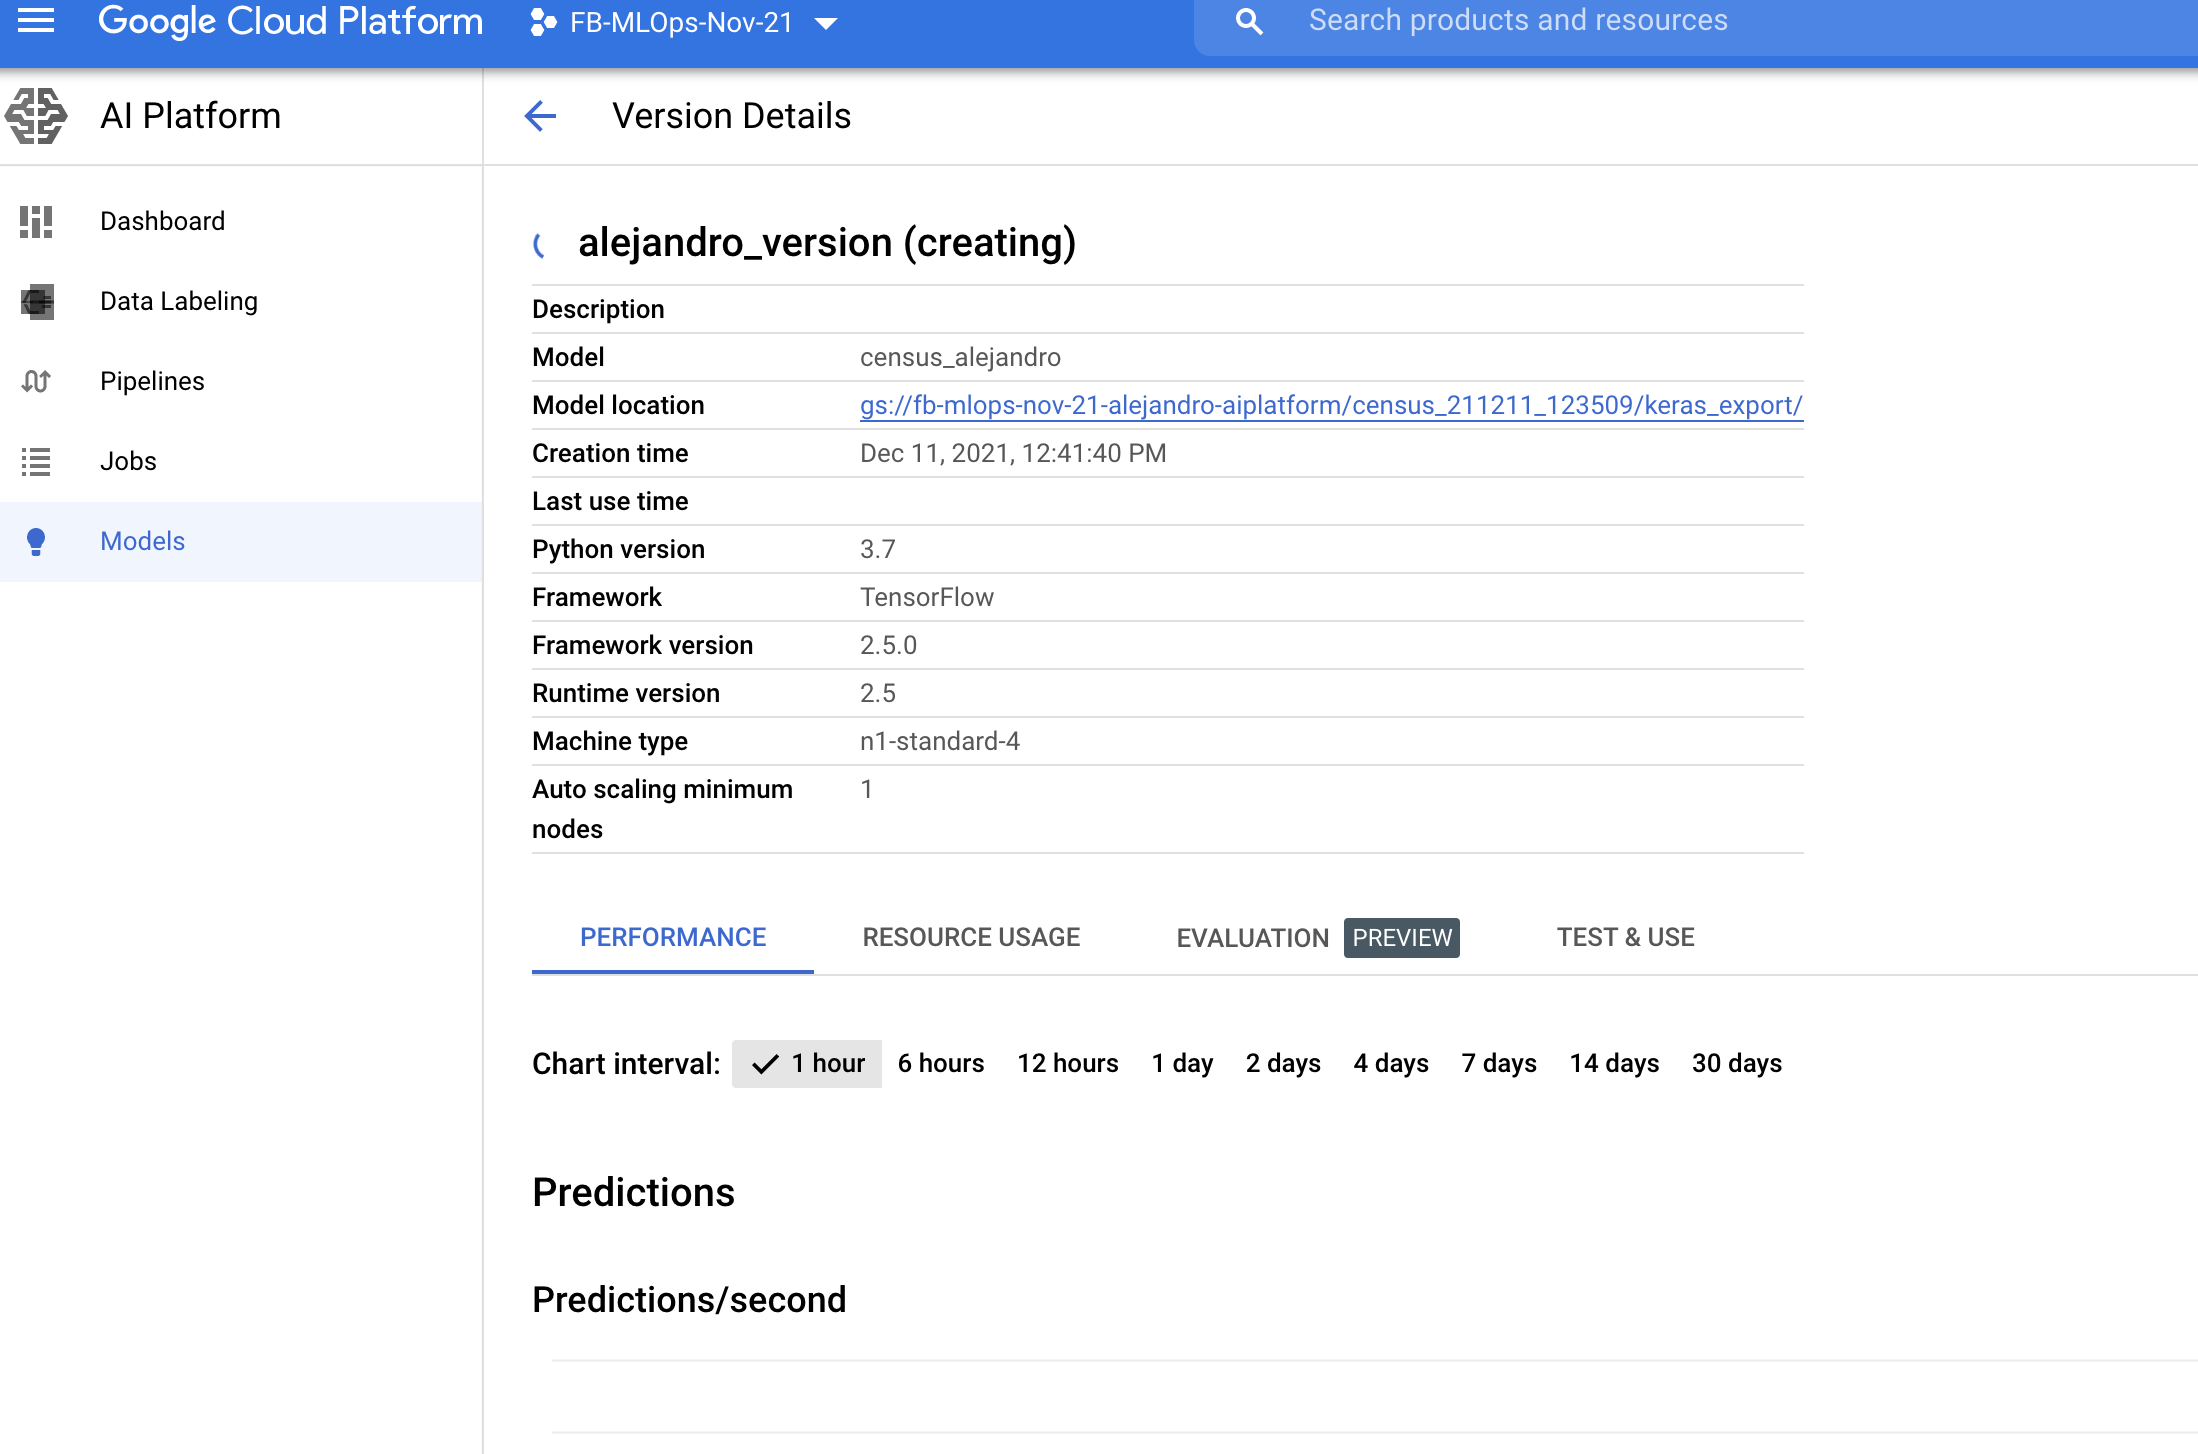

### Now your model and its version is created. Verify at https://console.cloud.google.com/ai-platform/models/
This step deploys your model. It may take sometime to complete.

#### 4: Finally, send an online prediction request to your deployed model!

You can now send prediction requests to your deployed model. The following command sends a prediction request using the test.json.

The response includes the probabilities of each label **(>50K and <=50K)** based on the data entry in test.json, thus indicating whether the predicted income is greater than or less than 50,000 dollars.

## If teh following command gives error, replace MODEL_NAME with census and MODEL_VERSION with your model version name and rerun!

In [101]:
MODEL_NAME = "census_alejandro" #REPLACE your firstname here
MODEL_VERSION = "alejandro_version" # Give a unique name <v_firstname>

In [103]:

! gcloud ai-platform predict --model $MODEL_NAME --version $MODEL_VERSION --json-instances ./test.json --region $REGION

Using endpoint [https://us-central1-ml.googleapis.com/]
[[0.000266164541], [0.092337817], [0.00132465363], [0.697567761], [0.000234484673]]


### Congratulations!

In this lab you've learned how to train a TensorFlow model both locally and on AI Platform, how to prepare data for prediction and to perform predictions both locally and in the Cloud AI Platform.

# CLEAN UP:
# Once you are done, remember to do the following:
## * DELETE the AI PLATFORM NOTEBOOK INSTANCE https://console.cloud.google.com/ai-platform/notebooks/list/instances
## * DELETE the AI PLATFORM MODEL VERSION followed by MODEL NAME (YOU WILL NOT BE ABLE TO DELETE MODEL NAME DIRECTLY) https://console.cloud.google.com/ai-platform/models?
## * DELETE THE GCP STORAGE BUCKET YOU CREATED! https://console.cloud.google.com/storage/browser




# Food to thought: Can you now think how to use this setup for another dataset?